In [1]:
from tweedledum.bool_function_compiler import BitVec, BoolFunction
# I go further with other hand optmizations
# (not really important for this discussion)
def fancy(v0, v1, v2, v3, v4, v5, v6 : BitVec(2)) -> BitVec(1):
    c1 = (v1[0] == v1[1]) and (v3 != v1)
    c023 = ((v0 ^ v2 ^ v3) == BitVec('00'))
    c4 = (v4 != v1) and (v4 != v3)
    c5 = (v5 != v2) and (v5 != v3)
    c6 = ((v2 ^ v3 ^ v5 ^ v6) == BitVec('00')) and (v6 != v4)
    return c1 and c023 and c4 and c5 and c6

oracle_func = BoolFunction(fancy)

## Configurations

In [2]:
oracle_type = 'fancy' # (naive, fancy)

# Optimization options
use_barenco_decomp = True
use_linear_resynth = True
use_diagonal_synth = True
use_xag_optimization = True
use_gate_cancellation = True

max_num_qubits = 32 # When using pkrm this plays an important role range(15..32)

## Concrete implementation

In [3]:
import numpy as np

from tweedledum.ir import Circuit, rotation_angle
from tweedledum.converters_qiskit import tweedledum_to_qiskit_qc
from tweedledum.passes import barenco_decomp, inverse, shallow_duplicate, gate_cancellation
from tweedledum.operators import H, Measure, Ry, X, Z
from tweedledum.synthesis import diagonal_synth, xag_synth, pkrm_synth, lhrs_synth
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller

def use_lhrs(bool_function, lhrs_config):
    circuit = lhrs_synth(bool_function.logic_network(), lhrs_config)
    decomp = shallow_duplicate(circuit)
    for inst in circuit:
        if inst.kind() == 'ext.truth_table':
            pkrm_synth(decomp, inst.qubits(), inst.cbits(), inst)
    return decomp

def use_pkrm(bool_function):
    return pkrm_synth(bool_function.truth_table(output_bit=0))

def use_xag(bool_function):
    from tweedledum.passes import parity_decomp, linear_resynth
    if use_xag_optimization:
        from tweedledum.classical import optimize
        optimize(bool_function.logic_network())
    circuit = xag_synth(bool_function.logic_network())
    if use_linear_resynth:
        circuit = linear_resynth(circuit)
    return parity_decomp(circuit)

def fancy_init():
    theta = 2 * np.arccos(1 / np.sqrt(3))
    circuit = Circuit()
    qubits = [circuit.create_qubit() for i in range(14)]
    #district0
    circuit.apply_operator(Ry(theta), [qubits[0]])
    circuit.apply_operator(H(), [qubits[0], qubits[1]])
    circuit.apply_operator(X(), [qubits[1]])

    #district1
    circuit.apply_operator(Ry(theta), [qubits[2]])
    circuit.apply_operator(H(), [qubits[2], qubits[3]])

    #district2
    circuit.apply_operator(H(), [qubits[4]])
    circuit.apply_operator(X(), [qubits[5]])

    #district3
    circuit.apply_operator(Ry(theta), [qubits[6]])
    circuit.apply_operator(H(), [qubits[6], qubits[7]])
    circuit.apply_operator(X(), [qubits[7]])

    #district4 B
    circuit.apply_operator(Ry(theta), [qubits[8]])
    circuit.apply_operator(H(), [qubits[8], qubits[9]])

    #district5
    circuit.apply_operator(Ry(theta), [qubits[10]])
    circuit.apply_operator(H(), [qubits[10], qubits[11]])
    circuit.apply_operator(X(), [qubits[10]])

    #district6
    circuit.apply_operator(Ry(theta), [qubits[12]])
    circuit.apply_operator(H(), [qubits[12], qubits[13]])
    circuit.apply_operator(X(), [qubits[12]])
        
    return circuit

In [9]:
for syntehsis_method in ['lhrs']:
    for max_cut_size in range(2, 15):
        lhrs_config = {'lhrs_synth' : {'max_cut_size' : max_cut_size}}
        oracle_circuit = use_lhrs(oracle_func, lhrs_config)
        num_qubits_range = [i for i in range(oracle_circuit.num_qubits(), 27)]
        if not num_qubits_range:
            num_qubits_range = [oracle_circuit.num_qubits()]
        for max_num_qubits in num_qubits_range:
            if use_barenco_decomp:
                oracle_circuit = barenco_decomp(oracle_circuit, {'max_qubits' : max_num_qubits})
                # print(f'oracle: {len(oracle_circuit)}')

            init_subcircuit = naive_init() if oracle_type == 'naive' else fancy_init()
            init_adj_subcircuit = inverse(init_subcircuit)

            diffuser_subcircuit = Circuit()
            qubits = [diffuser_subcircuit.create_qubit() for i in range(15)] 
            # Why 15? I need to account for the output qubit! Also if barenco is used
            # this qubit should be left alone as it where the output rests!

            diffuser_subcircuit.append(init_adj_subcircuit, qubits[0:init_subcircuit.num_qubits()], [])
            for qubit in qubits[0:14]:
                diffuser_subcircuit.apply_operator(X(), [qubit])
            diffuser_subcircuit.apply_operator(Z(), qubits[0:14])
            for qubit in qubits[0:14]:
                diffuser_subcircuit.apply_operator(X(), [qubit])
            diffuser_subcircuit.append(init_subcircuit, qubits[0:init_adj_subcircuit.num_qubits()], [])

            if use_barenco_decomp:
                diffuser_subcircuit = barenco_decomp(diffuser_subcircuit, {'max_qubits' : max_num_qubits})
                # diffuser_subcircuit = barenco_decomp(diffuser_subcircuit)

            # Initialize
            num_qubits = max(oracle_circuit.num_qubits(), diffuser_subcircuit.num_qubits())
            circuit = Circuit()
            qubits = [circuit.create_qubit() for i in range(num_qubits)]
            cbits = [circuit.create_cbit() for i in range(14)]

            circuit.apply_operator(X(), [qubits[14]])
            circuit.apply_operator(H(), [qubits[14]])

            circuit.append(init_subcircuit, qubits[0:init_subcircuit.num_qubits()], [])

            # Grover iteration
            num_iterations = 5
            # I hard code the number of iteration to 5 when using 'fancy' oracles 
            # because the contest said it was okay to do so. Howeverm, in theory,
            # this number should be sqrt(1458/9) ~ 12
            for i in range(num_iterations):
                circuit.append(oracle_circuit, qubits[0:oracle_circuit.num_qubits()], [])
                circuit.append(diffuser_subcircuit, qubits[0:diffuser_subcircuit.num_qubits()], [])

            if use_diagonal_synth:
                new_circuit = shallow_duplicate(circuit)
                for instruction in circuit:
                    if instruction.kind() == 'std.rx':
                        angle = rotation_angle(instruction)
                        qs = instruction.qubits()
                        angles = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -angle/2, angle/2]
                        new_circuit.apply_operator(H(), [qs[-1]])
                        diagonal_synth(new_circuit, qs, instruction.cbits(), angles)
                        new_circuit.apply_operator(H(), [qs[-1]])
                    else:
                        new_circuit.apply_operator(instruction)
                circuit = new_circuit

            for i in range(circuit.num_cbits()):
                circuit.apply_operator(Measure(), [qubits[i]], [cbits[i]])

            if use_gate_cancellation:
                circuit = gate_cancellation(circuit)
            
            qiskit_circuit = tweedledum_to_qiskit_qc(circuit)
            # Unroll the circuit
            pass_ = Unroller(['u', 'cx'])
            pm = PassManager(pass_)
            qiskit_circuit = pm.run(qiskit_circuit) 

            gates = qiskit_circuit.count_ops()
            cost = gates['u'] + (10 * gates['cx'])
            print(f'lhrs-{max_cut_size}-{max_num_qubits}', qiskit_circuit.num_qubits, cost)
        print('')

lhrs-2-53 53 22585

lhrs-3-37 37 24572

lhrs-4-27 27 37192

lhrs-5-25 25 61483
lhrs-5-26 26 41345

lhrs-6-22 22 146773
lhrs-6-23 23 148843
lhrs-6-24 24 150915
lhrs-6-25 25 152987
lhrs-6-26 26 132851

lhrs-7-20 20 114944
lhrs-7-21 21 117014
lhrs-7-22 22 119086
lhrs-7-23 23 121158
lhrs-7-24 24 123230
lhrs-7-25 25 125302
lhrs-7-26 26 105166

lhrs-8-19 19 222902
lhrs-8-20 20 224972
lhrs-8-21 21 227044
lhrs-8-22 22 229116
lhrs-8-23 23 231188
lhrs-8-24 24 233260
lhrs-8-25 25 235332
lhrs-8-26 26 215196

lhrs-9-19 19 110452
lhrs-9-20 20 112522
lhrs-9-21 21 114594
lhrs-9-22 22 116666
lhrs-9-23 23 118738
lhrs-9-24 24 120810
lhrs-9-25 25 122882
lhrs-9-26 26 102746

lhrs-10-17 17 498257
lhrs-10-18 18 496917
lhrs-10-19 19 498319
lhrs-10-20 20 500391
lhrs-10-21 21 502463
lhrs-10-22 22 504535
lhrs-10-23 23 506607
lhrs-10-24 24 508679
lhrs-10-25 25 510751
lhrs-10-26 26 490615

lhrs-11-16 16 1163940
lhrs-11-17 17 1164870
lhrs-11-18 18 1163532
lhrs-11-19 19 1164934
lhrs-11-20 20 1167006
lhrs-11-21 21 11

In [10]:
oracle_circuit = use_xag(oracle_func)

if use_barenco_decomp:
    oracle_circuit = barenco_decomp(oracle_circuit, {'max_qubits' : max_num_qubits})

init_subcircuit = naive_init() if oracle_type == 'naive' else fancy_init()
init_adj_subcircuit = inverse(init_subcircuit)

diffuser_subcircuit = Circuit()
qubits = [diffuser_subcircuit.create_qubit() for i in range(15)] 
# Why 15? I need to account for the output qubit! Also if barenco is used
# this qubit should be left alone as it where the output rests!

diffuser_subcircuit.append(init_adj_subcircuit, qubits[0:init_subcircuit.num_qubits()], [])
for qubit in qubits[0:14]:
    diffuser_subcircuit.apply_operator(X(), [qubit])
diffuser_subcircuit.apply_operator(Z(), qubits[0:14])
for qubit in qubits[0:14]:
    diffuser_subcircuit.apply_operator(X(), [qubit])
diffuser_subcircuit.append(init_subcircuit, qubits[0:init_adj_subcircuit.num_qubits()], [])

if use_barenco_decomp:
    diffuser_subcircuit = barenco_decomp(diffuser_subcircuit, {'max_qubits' : max_num_qubits})

# Initialize
num_qubits = max(oracle_circuit.num_qubits(), diffuser_subcircuit.num_qubits())
circuit = Circuit()
qubits = [circuit.create_qubit() for i in range(num_qubits)]
cbits = [circuit.create_cbit() for i in range(14)]

circuit.apply_operator(X(), [qubits[14]])
circuit.apply_operator(H(), [qubits[14]])

circuit.append(init_subcircuit, qubits[0:init_subcircuit.num_qubits()], [])

# Grover iteration
num_iterations = 5
# I hard code the number of iteration to 5 when using 'fancy' oracles 
# because the contest said it was okay to do so. Howeverm, in theory,
# this number should be sqrt(1458/9) ~ 12
for i in range(num_iterations):
    circuit.append(oracle_circuit, qubits[0:oracle_circuit.num_qubits()], [])
    circuit.append(diffuser_subcircuit, qubits[0:diffuser_subcircuit.num_qubits()], [])

if use_diagonal_synth:
    new_circuit = shallow_duplicate(circuit)
    for instruction in circuit:
        if instruction.kind() == 'std.rx':
            angle = rotation_angle(instruction)
            qs = instruction.qubits()
            angles = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -angle/2, angle/2]
            new_circuit.apply_operator(H(), [qs[-1]])
            diagonal_synth(new_circuit, qs, instruction.cbits(), angles)
            new_circuit.apply_operator(H(), [qs[-1]])
        else:
            new_circuit.apply_operator(instruction)
    circuit = new_circuit

for i in range(circuit.num_cbits()):
    circuit.apply_operator(Measure(), [qubits[i]], [cbits[i]])

if use_gate_cancellation:
    circuit = gate_cancellation(circuit)

qiskit_circuit = tweedledum_to_qiskit_qc(circuit)
# Unroll the circuit
pass_ = Unroller(['u', 'cx'])
pm = PassManager(pass_)
qiskit_circuit = pm.run(qiskit_circuit) 

gates = qiskit_circuit.count_ops()
cost = gates['u'] + (10 * gates['cx'])
print('xag', qiskit_circuit.num_qubits, cost)

xag 30 19065


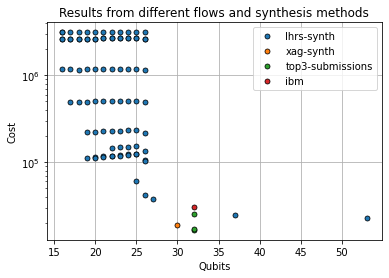

In [85]:
%matplotlib inline

from operator import itemgetter
from itertools import groupby
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
import numpy as np

def keep_efficient(pts):
    pts.sort(key=lambda pt: pt[0])
    groups = groupby(pts, itemgetter(0))
    return [ [key, min([item[1] for item in data])] for (key, data) in groups ]

    # for i in range(pts.shape[0]):
    #     # process each point in turn
    #     n = pts.shape[0]
    #     if i >= n:
    #         break
    #     # find all points not dominated by i
    #     # since points are sorted by coordinate sum
    #     # i cannot dominate any points in 1,...,i-1
    #     undominated[i+1:n] = (pts[i+1:] >= pts[i]).any(1) 
    #     # keep points undominated so far
    #     pts = pts[undominated[:n]]
    # return pts

lhrs = [[53, 22585], [37, 24572], [27, 37192], [25, 61483], [26, 41345], [22, 146773], [23, 148843], [24, 150915], [25, 152987], [26, 132851], [20, 114944], [21, 117014], [22, 119086], [23, 121158], [24, 123230], [25, 125302], [26, 105166], [19, 222902], [20, 224972], [21, 227044], [22, 229116], [23, 231188], [24, 233260], [25, 235332], [26, 215196], [19, 110452], [20, 112522], [21, 114594], [22, 116666], [23, 118738], [24, 120810], [25, 122882], [26, 102746], [17, 498257], [18, 496917], [19, 498319], [20, 500391], [21, 502463], [22, 504535], [23, 506607], [24, 508679], [25, 510751], [26, 490615], [16, 1163940], [17, 1164870], [18, 1163532], [19, 1164934], [20, 1167006], [21, 1169078], [22, 1171150], [23, 1173222], [24, 1175294], [25, 1177366], [26, 1157230], [16, 2641280], [17, 2642210], [18, 2640872], [19, 2642274], [20, 2644346], [21, 2646418], [22, 2648490], [23, 2650562], [24, 2652634], [25, 2654706], [26, 2634570], [16, 2641280], [17, 2642210], [18, 2640872], [19, 2642274], [20, 2644346], [21, 2646418], [22, 2648490], [23, 2650562], [24, 2652634], [25, 2654706], [26, 2634570], [16, 3114122], [16, 3109132], [17, 3110062], [18, 3108724], [19, 3110126], [20, 3112198], [21, 3114270], [22, 3116342], [23, 3118414], [24, 3120486], [25, 3122558], [26, 3102422]]

# keep_efficient(lhrs)
# lhrs = keep_efficient(lhrs)
# print(lhrs)

x = [p[0] for p in lhrs]
y = [p[1] for p in lhrs]

plt.plot(x, y, label='lhrs-synth', marker='o', markeredgewidth=0.75, linestyle='None', markersize=5,  markeredgecolor='black')
plt.plot([30], [19065], label='xag-synth', marker='o', markeredgewidth=0.75, linestyle='None', markersize=5,  markeredgecolor='black')
plt.plot([32, 32, 32], [16613, 17053, 25490], label='top3-submissions', marker='o', markeredgewidth=0.75, linestyle='None', markersize=5,  markeredgecolor='black')
plt.plot([32], [30667], label='ibm', marker='o', markeredgewidth=0.75, linestyle='None', markersize=5,  markeredgecolor='black')
plt.grid(True)
plt.title('Results from different flows and synthesis methods')
plt.ylabel('Cost')
plt.yscale('log')
plt.xlabel('Qubits')
plt.legend()

# plt.show()
plt.savefig('oracle_ret.png', bbox_inches='tight', dpi=1200)